In [ ]:
!pip install procgen
!pip install transformers
!pip install gym==0.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701346 sha256=b9d03db8235e39778dd62c72a2a38f

In [ ]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import matplotlib.pyplot as plt
from PIL import Image

import gym
import numpy as np
import torch
import torch.nn as nn
from procgen import ProcgenEnv
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
import requests
from transformers import CLIPProcessor, CLIPModel

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


device(type='cuda')

In [ ]:
PATH_TO_WEIGHT = '/content/weights105001344_maze.pt'

In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ppo/#ppo_procgenpy
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)

    def forward(self, x):
        inputs = x
        x = nn.functional.relu(x)
        x = self.conv0(x)
        x = nn.functional.relu(x)
        x = self.conv1(x)
        return x + inputs


class ConvSequence(nn.Module):
    def __init__(self, input_shape, out_channels):
        super().__init__()
        self._input_shape = input_shape
        self._out_channels = out_channels
        self.conv = nn.Conv2d(in_channels=self._input_shape[0], out_channels=self._out_channels, kernel_size=3, padding=1)
        self.res_block0 = ResidualBlock(self._out_channels)
        self.res_block1 = ResidualBlock(self._out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.res_block0(x)
        x = self.res_block1(x)
        assert x.shape[1:] == self.get_output_shape()
        return x

    def get_output_shape(self):
        _c, h, w = self._input_shape
        return (self._out_channels, (h + 1) // 2, (w + 1) // 2)


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        h, w, c = envs.single_observation_space.shape
        shape = (c, h, w)
        conv_seqs = []
        for out_channels in [16, 32, 32]:
            conv_seq = ConvSequence(shape, out_channels)
            shape = conv_seq.get_output_shape()
            conv_seqs.append(conv_seq)
        conv_seqs += [
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features=shape[0] * shape[1] * shape[2], out_features=256),
            nn.ReLU(),
        ]
        self.network = nn.Sequential(*conv_seqs)
        self.actor = layer_init(nn.Linear(256, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(256, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x.permute((0, 3, 1, 2)) / 255.0))  # "bhwc" -> "bchw"

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)  # "bhwc" -> "bchw"
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [ ]:
def run_a_level(level, print_episodes=True):
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)

    # env setup
    envs = ProcgenEnv(num_envs=1, env_name='maze', num_levels=1, start_level=level, distribution_mode="easy")
    envs = gym.wrappers.TransformObservation(envs, lambda obs: obs["rgb"])
    envs.single_action_space = envs.action_space
    envs.single_observation_space = envs.observation_space["rgb"]
    envs.is_vector_env = True
    envs = gym.wrappers.RecordEpisodeStatistics(envs)
    # envs = gym.wrappers.RecordVideo(envs, f"videos/")
    envs = gym.wrappers.NormalizeReward(envs, gamma=0.999)
    envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"


    agent = Agent(envs).to(device)
    agent.load_state_dict(torch.load(PATH_TO_WEIGHT, map_location=torch.device('cpu')))
    num_steps = 500

    # ALGO Logic: Storage setup
    rewards = torch.zeros((num_steps)).to(device)
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(1).to(device)

    PATH = f"game_imgs/{level}"
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    for step in range(num_steps):
        img = envs.render(mode="rgb_array")
        im = Image.fromarray(img)
        im.save(f"game_imgs/{level}/step{step}.jpeg")

        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs = torch.Tensor(next_obs).to(device)
        if print_episodes:
            print(f'step={step}, reward={reward}')
        if done[0]:
            if print_episodes:
                print('game done')
            break

    if not done[0] and print_episodes:
        print('game not finished')

    envs.close()

    return step, torch.sum(rewards).item()!=0

max_step = 0
max_level = 0
for level in range(200):
    steps, done = run_a_level(level, print_episodes=False)
    if done and steps>max_step:
        print(f'level={level}, steps={steps}')
        max_step = steps
        max_level = level
print(f'max_level={max_level}, max_step={max_step}')

level=1, steps=22
level=4, steps=23
level=7, steps=28
level=18, steps=29
level=26, steps=34
level=49, steps=41
max_level=49, max_step=41


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
scores = []
prompts = [
                        "a maze with the white sprite near the yellow sprite.",
                        "a maze with the white and yellow sprite near each other",
                        "a maze with the white shape near the yellow shape.",
                        "a maze with the white and yellow shape near each other",

                        "a maze with the white sprite far from the yellow sprite.",
                        "a maze with the white and yellow sprite far from each other",
                        "a maze with the white shape far from the yellow shape.",
                        "a maze with the white and yellow shape far each other",
            ]
for i in range(41):
    image = Image.open(f"game_imgs/49/step{i}.jpeg")
    with torch.no_grad():
      inputs = processor(text=prompts, images=torch.tensor(np.array(image)), return_tensors="pt", padding=True).to(device)
      outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    scores.append((logits_per_image, probs))

In [ ]:
print(torch.matmul(outputs.image_embeds, outputs.text_embeds.T)*100)
print(outputs.logits_per_image)

tensor([[28.4611, 28.4967, 27.0710, 26.4530, 27.3500, 27.7958, 26.6309, 26.3378]],
       device='cuda:0')
tensor([[28.4611, 28.4967, 27.0710, 26.4530, 27.3500, 27.7958, 26.6309, 26.3378]],
       device='cuda:0')


In [ ]:
scores_normal = {}
for i,prompt in enumerate(prompts):
    scores_normal[prompt] = []
    for score in scores:
        logit, prob = score
        scores_normal[prompt].append(logit[0][i].item())

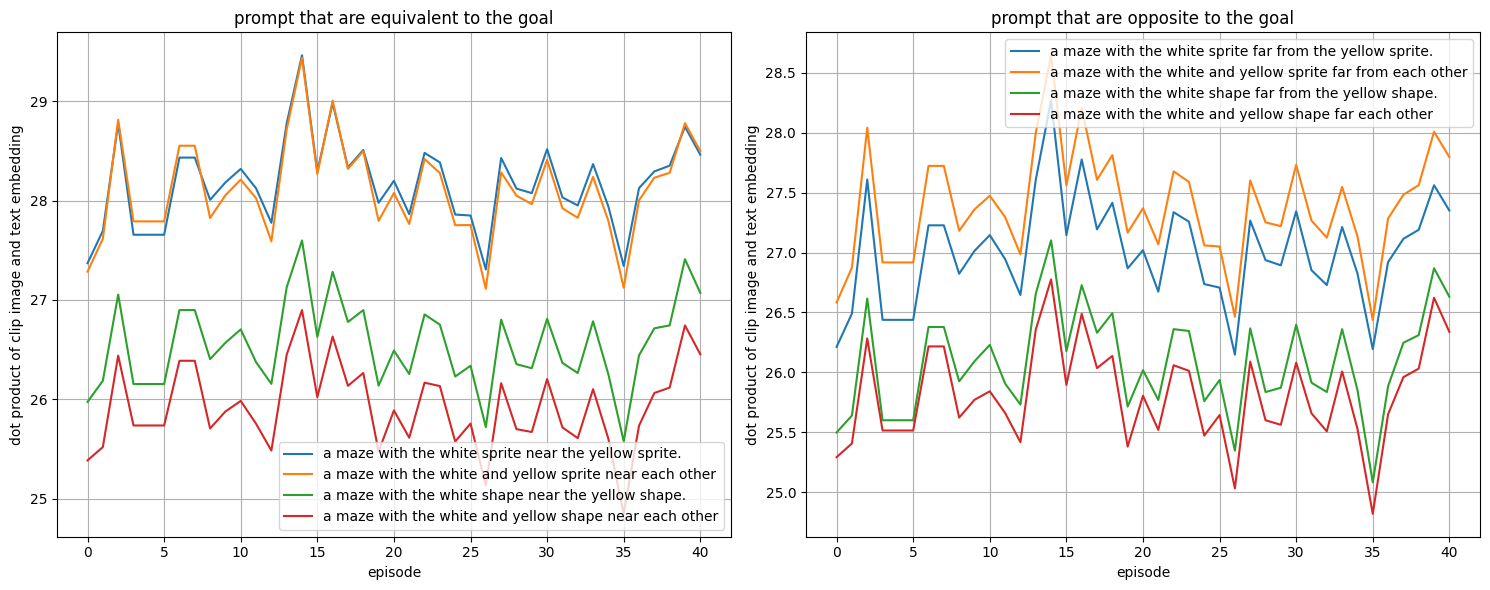

In [ ]:
import matplotlib.pyplot as plt

data1 = {
    prompt : scores_normal[prompt] for prompt in prompts[0:4]
}

data2 = {
    prompt : scores_normal[prompt] for prompt in prompts[4:]
}

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting on the first subplot
for key, values in data1.items():
    ax1.plot(values, label=key)
ax1.set_title("prompt that are equivalent to the goal")
ax1.set_xlabel("episode")
ax1.set_ylabel("dot product of clip image and text embedding")
ax1.legend()
ax1.grid(True)

# Plotting on the second subplot
for key, values in data2.items():
    ax2.plot(values, label=key)
ax2.set_title("prompt that are opposite to the goal")
ax2.set_xlabel("episode")
ax2.set_ylabel("dot product of clip image and text embedding")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
scores = []
prompts = [
                        "a maze with a white sprite near a yellow sprite.",
                        "a maze with a white sprite not near a yellow sprite.",
          ]
for i in range(41):
    image = Image.open(f"game_imgs/49/step{i}.jpeg")
    with torch.no_grad():
      inputs = processor(text=prompts, images=torch.tensor(np.array(image)), return_tensors="pt", padding=True).to(device)
      outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score

    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    scores.append((logits_per_image, probs))

In [ ]:
scores_normal = []
for _, probs in scores:
  prob_pos, prob_neg = probs[0][0].item(), probs[0][1].item()
  scores_normal.append(prob_pos)

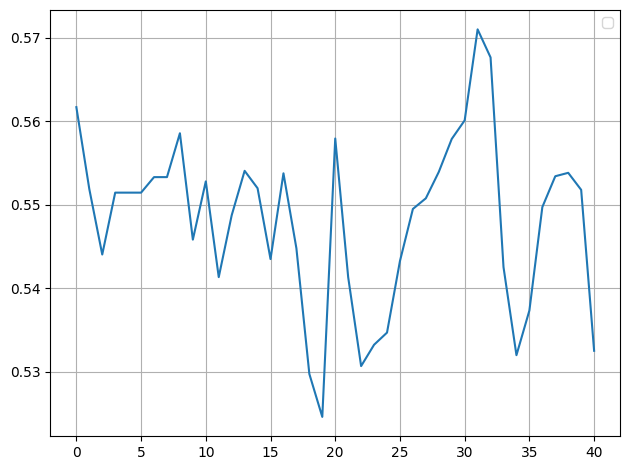

In [ ]:
plt.plot(scores_normal)
# plt.set_title("prompt that are equivalent to the goal")
# plt.set_xlabel("episode")
# plt.set_ylabel("dot product of clip image and text embedding")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Dynamic Text

In [ ]:
# create dataset
from os import listdir
from os.path import isfile, join
dataset_list = []
for level in range(200):
    path = f'game_imgs/{level}'
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and '.jpeg' in f]
    total_step = len(onlyfiles)

    if total_step>50:
        print('skipping bad episode')
        continue
    for step in range(total_step):
        img = f'game_imgs/{level}/step{step}.jpeg'
        reward = 1 * (0.95**(total_step-step-1))
        dataset_list.append((img,reward))

skipping bad episode
skipping bad episode
skipping bad episode
skipping bad episode
skipping bad episode


In [ ]:
len(dataset_list)

2491

In [ ]:
class RewardDataset(Dataset):
    def __init__(self, dataset_list, transform=None):
        self.dataset_list = dataset_list
        self.transform = transform

    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, idx):
        path, reward = self.dataset_list[idx]

        image =  Image.open(path)
        image = torch.tensor(np.array(image))


        if self.transform:
            image = self.transform(image)

        return image, reward

dataset_torch = RewardDataset(dataset_list)

In [ ]:
class RewardModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        # self.img_network =  nn.Sequential(
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 512)
        # )

        self.txt_network1 =  nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

        # self.txt_network2 =  nn.Sequential(
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 512)
        # )



    def forward(self, clip_img, clip_text):
        clip_text1, clip_text2 = clip_text[0,:], clip_text[1,:]
        clip_img = clip_img # batch_size * 512
        clip_txt1 = self.txt_network1(clip_text1) # 1 * 512
        clip_txt2 = clip_text2 # 1 * 512
        # clip_txt2 = self.txt_network2(clip_text2) # 1 * 512
        sim1 = torch.matmul(clip_img, clip_txt1.T).reshape((-1, 1)) # batch * 1
        sim2 = torch.matmul(clip_img, clip_txt2.T).reshape((-1, 1)) # batch * 1

        probs = torch.cat((sim1,sim2), dim=1).softmax(dim=1) # batch * 2
        score = probs[:,0] - probs[:,0]

        return score, clip_img, (clip_txt1, clip_txt2)


model_reward = RewardModel().to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
batch_size = 512
train_loader = DataLoader(dataset_torch, batch_size=batch_size, shuffle=True)

# training loop
mse = torch.nn.MSELoss()
learning_rate= 4e-4
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# text_embedding = torch.zeros((1, 512), requires_grad=True, device=device, dtype=torch.float32)

optimizer = torch.optim.Adam(model_reward.parameters(), lr=learning_rate)
model_reward.train()
print(f'learning rate={learning_rate} batch_size={batch_size} num_epochs={num_epochs}')
losses = []
for epoch in range(num_epochs):
    train_loss  = 0
    for batch, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = y.reshape((-1, 1)).to(device).float()

        with torch.no_grad():
          inputs = processor(text=[
                        "a maze with a white sprite near a yellow sprite.",
                        "a maze with a white sprite far from a yellow sprite.",
          ], images=x, return_tensors="pt", padding=True).to(device)
          outputs = model(**inputs)

        score, clip_img, clip_txt = model_reward(outputs.image_embeds, outputs.text_embeds)

        loss = mse(score.reshape((-1,1)), y)

        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
        scores.append((logits_per_image, probs))

        train_loss += loss.item()*train_loader.batch_size

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    losses.append(train_loss)
    print(f"[Epoch {epoch}]\t"
        f"Loss :{train_loss:.4f}\t"
    )
    if train_loss<0.07:
      break

learning rate=0.0004 batch_size=512 num_epochs=100


0it [00:00, ?it/s]

In [ ]:
scores = []
model_reward.eval()
for i in range(41):
    image = Image.open(f"game_imgs/49/step{i}.jpeg")
    with torch.no_grad():
      inputs = processor(text=[
                        "a maze with a white sprite near a yellow sprite.",
                        "a maze with a white sprite far from a yellow sprite.",
          ], images=image, return_tensors="pt", padding=True).to(device)
      outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    score, clip_img, clip_txt = model_reward(outputs.image_embeds, outputs.text_embeds)

    scores.append(score.cpu().item())

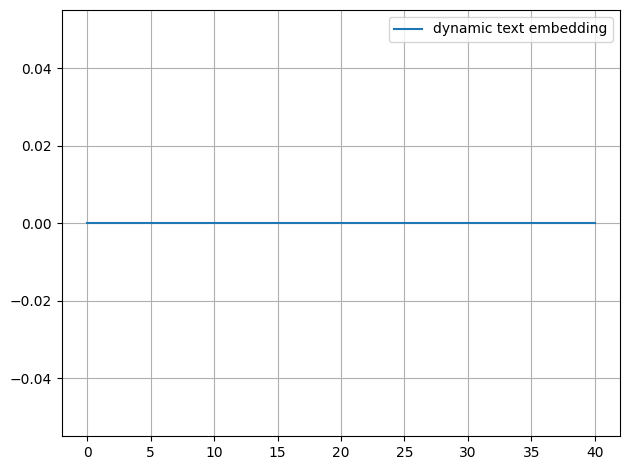

In [ ]:
import matplotlib.pyplot as plt

plt.plot(scores, label='dynamic text embedding')

plt.legend()
plt.grid(True)

ax2.grid(True)
plt.tight_layout()
plt.show()